# Combine workgraphs

## Introduction

In designing a complex workflow, it is often desired to reuse smaller, reusable components. In the following sections, we will create a simple, reusable workgraph and integrate it into another.

## Define a reusable workgraph

To start, let's define a couple of simple arithmetic tasks and combine them in a workgraph. We will wrap it in a generating function so that we can easily reuse it in our two approaches.

In [1]:
from aiida_workgraph import WorkGraph, task


@task
def add(x, y):
    return x + y


@task
def multiply(x, y):
    return x * y


def add_multiply(x=None, y=None, z=None):
    with WorkGraph("AddMultiply") as wg:
        sum_ = add(x=x, y=y)
        prod = multiply(x=sum_, y=z)
        wg.outputs.result = prod.result
    return wg

We define the `add_multiply` workgraph generator with optional inputs, so that we can provide them later after integrating the workgraph into another.

Let's see what the workgraph looks like.

In [2]:
add_multiply(x=1, y=2, z=3).to_dict()

{'platform_version': 'aiida_workgraph@0.5.3',
 'uuid': '6396cb46-5e76-11f0-87c3-00155dc4a75e',
 'name': 'AddMultiply',
 'state': 'CREATED',
 'action': 'NONE',
 'error': '',
 'metadata': {'graph_type': 'NORMAL'},
 'meta_sockets': {'graph_ctx': {'name': 'inputs',
   'identifier': 'workgraph.namespace',
   'link_limit': 1000000.0,
   'links': [],
   'metadata': {'dynamic': True,
    'required': False,
    'builtin_socket': False,
    'function_socket': False,
    'socket_type': 'INPUT',
    'arg_type': 'kwargs'},
   'sockets': {}},
  'graph_inputs': {'name': 'outputs',
   'identifier': 'workgraph.namespace',
   'link_limit': 1000000.0,
   'links': [],
   'metadata': {'dynamic': True,
    'required': False,
    'builtin_socket': False,
    'function_socket': False,
    'socket_type': 'INPUT',
    'arg_type': 'kwargs'},
   'sockets': {}},
  'graph_outputs': {'name': 'inputs',
   'identifier': 'workgraph.namespace',
   'link_limit': 1000000.0,
   'links': [],
   'metadata': {'dynamic': True,

We can see our two tasks, the linking of the sum to the first multiplication factor, and the assignment of the product as the final workgraph result.

We're now ready to integrate our new *AddMultiply* workgraph into other workgraphs.

## Adding a workgraph as a task

Adding an existing workgraph as a task in another workgraph is straightforward. We first create a new workgraph, *AddMultiplyComposed*, and inject a new task to generate a random number. Next, we obtain the *AddMultiply* workgraph by calling its generating function `add_multiply`, then call the *AddMultiply* workgraph with `inputs`, including a linked input assigning the random number to `z` (the multiplication factor of the `multiply` task).

In [3]:
@task
def generate_random_number(minimum, maximum):
    import random

    return random.randint(minimum, maximum)


with WorkGraph("AddMultiplyComposed") as wg:
    random_number_output = generate_random_number(minimum=1, maximum=10)
    outputs = add_multiply()(
        inputs={
            "x": 1,
            "y": 2,
            "z": random_number_output.result,
        }
    )
    wg.outputs.result = outputs.result

wg.to_html()

In [4]:
from aiida import load_profile

_ = load_profile()

wg.submit()

WorkGraph process created, PK: 8839


<WorkGraphNode: uuid: 4e58542e-7d65-41ff-8884-d93410702d84 (pk: 8839) (aiida.workflows:workgraph.engine)>

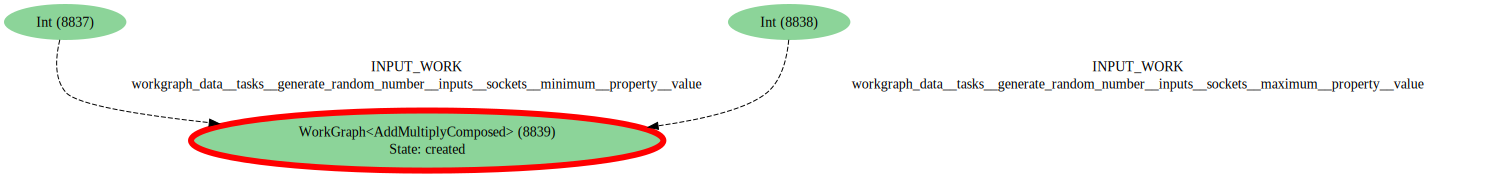

In [5]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg.pk)

Note that when adding a workgraph as a task, it is visualized as a single task. However, the task may be inspected in the workgraph GUI to inspect the inner workings of the workgraph task.

## Summary

In this tutorial, we have seen how to combine workgraphs by adding a workgraph as a task of another.